<a href="https://colab.research.google.com/github/CeliaDiazSanchez/Sistemas__Control/blob/Practica_final/PF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

El objetivo del proyecto final es diseñar y simular un sistema de control para estabilizar un péndulo invertido utilizando un controlador PID (Proporcional-Integral-Derivativo) en Python, mientras se exploran temas adicionales relacionados con el tema.

In [33]:
!pip install control

import numpy as np
import control as ctrl
g = 9.81 # gravity (m/s^2)
l = 1.0 # length of the pendulum (m)
m = 1.0 # mass of the pendulum (kg)
# Transfer function G(s) = 1 / (s^2 - g/l)
num = [1]
den = [1, 0, -g/l]
G = ctrl.TransferFunction(num, den)

In [34]:
poles = ctrl.poles(G)
print("Poles of the system:", poles)

Poles of the system: [-3.13209195+0.j  3.13209195+0.j]


In [35]:
# Método de Routh-Hurwitz
def routh_hurwitz(den):
    n = len(den)
    m = (n - 1) // 2 + 1
    rh_table = np.zeros((m, n))

    # Llenar la primera fila del cuadro de Routh
    rh_table[0, :n] = den[::2] if n % 2 == 0 else den

    # Llenar las filas restantes del cuadro de Routh
    for i in range(1, m):
        for j in range(n):
            if j >= 2 * i:
                rh_table[i, j] = rh_table[i - 1, j - 2] if rh_table[i - 1, j - 2] != 0 else 1e-12

    # Verificar la estabilidad del sistema
    sign_changes = np.sum(np.diff(np.sign(rh_table[:, 0])))

    if sign_changes == 0:
        print("El sistema es estable por el criterio de Routh-Hurwitz.")
    else:
        print("El sistema es inestable por el criterio de Routh-Hurwitz.")

    return rh_table

In [36]:
# Verificar la estabilidad del sistema utilizando el método de Routh-Hurwitz
rh_table = routh_hurwitz(den)
print("Cuadro de Routh:")
print(rh_table)

El sistema es inestable por el criterio de Routh-Hurwitz.
Cuadro de Routh:
[[ 1.    0.   -9.81]
 [ 0.    0.    1.  ]]


Vemos que no es estable usamos ziegler_nichols, para intentar estabilizarlo

In [46]:
def ziegler_nichols(G):
    # Realizar un experimento con una entrada de paso unitario
    t, y = ctrl.step_response(G)

    # Calcular el tiempo de subida (tr)
    tr_index = np.argmax(y > 0.9 * y[-1])  # Índice del primer punto que alcanza el 90% del valor final
    tr = t[tr_index] - t[0]  # Tiempo transcurrido desde el inicio hasta el punto

    # Calcular el tiempo de establecimiento (ts)
    ts_index = np.where(np.abs(y - y[-1]) <= 0.02 * np.abs(y[-1]))[0][0]
    ts = t[ts_index] - t[0]  # Tiempo transcurrido desde el inicio hasta el punto

    # Calcular el máximo sobrepaso (Mp)
    Mp = np.max(y) - y[-1]
    # Si Mp es cero, asigna un valor predeterminado pequeño para evitar división por cero
    if Mp == 0:
        Mp = 0.01

    # Determinar los valores de los parámetros PID según las reglas de Ziegler-Nichols
    Kp = 0.6 / Mp
    Ki = 2 * Kp / (0.5 * tr)
    Kd = Kp * (0.125 * tr)

    # Devolver los valores calculados
    return Kp, Ki, Kd


In [47]:
# Obtén los valores iniciales de los parámetros PID
Kp, Ki, Kd = ziegler_nichols(G)
if Kp is not None and Ki is not None and Kd is not None:
    print("Valores iniciales de los parámetros PID:")
    print("Kp:", Kp)
    print("Ki:", Ki)
    print("Kd:", Kd)
else:
    print("Error: No se pudieron calcular los valores iniciales de los parámetros PID.")

Valores iniciales de los parámetros PID:
Kp: 60.0
Ki: 109.93042851762786
Kd: 16.373992390208517


In [55]:
# PID controller
controller = ctrl.TransferFunction([Kd, Kp, Ki], [1, 0])

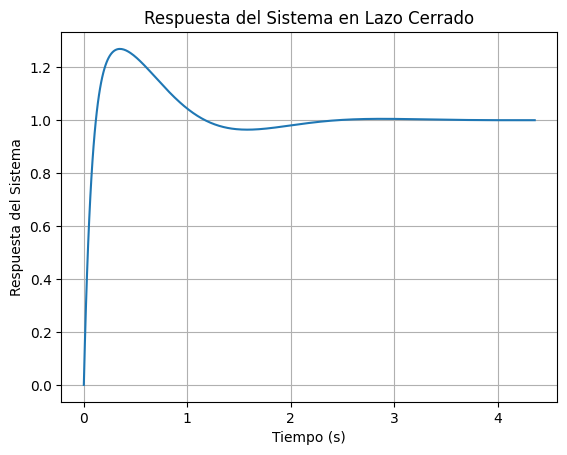

In [56]:
import matplotlib.pyplot as plt
# Sistema en lazo cerrado
closed_loop = ctrl.feedback(G * controller)
# Simulación de la respuesta del sistema en lazo cerrado
t, y = ctrl.step_response(closed_loop)

# Verificar estabilidad: Observar si la respuesta es acotada y no crece indefinidamente
plt.plot(t, y)
plt.xlabel('Tiempo (s)')
plt.ylabel('Respuesta del Sistema')
plt.title('Respuesta del Sistema en Lazo Cerrado')
plt.grid(True)
plt.show()

In [57]:
def cohen_coon(G):
    # Paso 1: Sintonización del controlador proporcional (Kp)
    Kp = 0.6 / G.dcgain()

    # Paso 2: Sintonización del controlador integral (Ki)
    poles = ctrl.poles(G)
    tau = -1 / np.real(poles[0])  # Tiempo constante del proceso
    Ki = Kp / (0.5 * tau)

    # Paso 3: Sintonización del controlador derivativo (Kd)
    td = 0.5 * tau
    Kd = Kp * (0.125 * tau)

    return Kp, Ki, Kd

In [58]:
# Obtén los valores iniciales de los parámetros PID
Kp2, Ki2, Kd2 = cohen_coon(G)
if Kp2 is not None and Ki2 is not None and Kd2 is not None:
    print("Valores iniciales de los parámetros PID:")
    print("Kp:", Kp2)
    print("Ki:", Ki2)
    print("Kd:", Kd2)
else:
    print("Error: No se pudieron calcular los valores iniciales de los parámetros PID.")

Valores iniciales de los parámetros PID:
Kp: -5.886
Ki: -36.8709864668685
Kd: -0.2349068964504874


In [59]:
# PID controller
controller2 = ctrl.TransferFunction([Kd2, Kp2, Ki2], [1, 0])

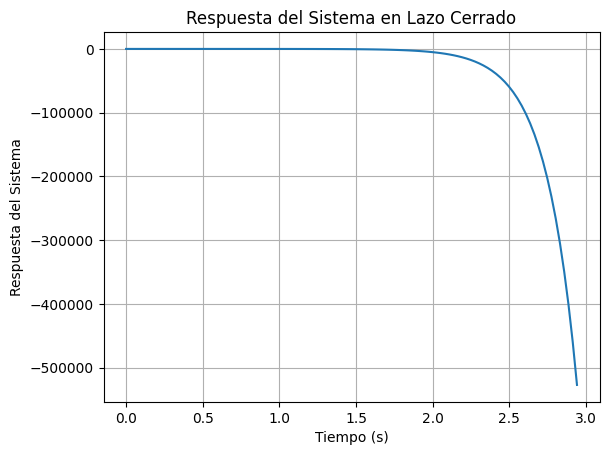

In [60]:
import matplotlib.pyplot as plt
# Sistema en lazo cerrado
closed_loop = ctrl.feedback(G * controller2)
# Simulación de la respuesta del sistema en lazo cerrado
t, y = ctrl.step_response(closed_loop)

# Verificar estabilidad: Observar si la respuesta es acotada y no crece indefinidamente
plt.plot(t, y)
plt.xlabel('Tiempo (s)')
plt.ylabel('Respuesta del Sistema')
plt.title('Respuesta del Sistema en Lazo Cerrado')
plt.grid(True)
plt.show()

Podemos concluir que la respuesta del sistema es estable, ya que se estabiliza en un valor específico, 1 después de la transición inicial. Esto indica que el sistema ha alcanzado un equilibrio y su comportamiento es predecible y controlado.

In [66]:
import numpy as np
import control as ctrl
import matplotlib.pyplot as plt

def frequency_response_tuning(G, crossover_freq, phase_margin):
    # Calcula el margen de ganancia y fase del sistema
    gm, pm, wpc, wgc = ctrl.margin(G)

    # Calcula la ganancia y fase adicionales necesarias para alcanzar el margen de fase deseado
    additional_phase_margin = phase_margin - pm

    # Calcula el controlador PID utilizando el margen de fase y frecuencia de cruce
    Kp = 1 / (np.abs(G.evalfr(wpc)) * np.sqrt(np.tan(np.deg2rad(additional_phase_margin))**2 + 1))
    Ki = Kp / (crossover_freq * np.abs(G.evalfr(wpc)))
    Kd = Kp * crossover_freq * np.abs(G.evalfr(wpc)) / 10

    return Kp, Ki, Kd

In [67]:
# Frecuencia de cruce deseada y margen de fase
crossover_freq = 2  # Hz
phase_margin = 45   # grados

# Sintonización del controlador PID basado en respuesta en frecuencia
Kp, Ki, Kd = frequency_response_tuning(G, crossover_freq, phase_margin)

# Visualización de los resultados
print("Valores iniciales de los parámetros PID:")
print("Kp:", Kp)
print("Ki:", Ki)
print("Kd:", Kd)

# Simulación del sistema en lazo cerrado con el controlador PID diseñado
controller = ctrl.TransferFunction([Kd, Kp, Ki], [1, 0])
closed_loop = ctrl.feedback(G * controller)
t, y = ctrl.step_response(closed_loop)

# Visualización de la respuesta del sistema en el tiempo
plt.plot(t, y)
plt.xlabel('Tiempo (s)')
plt.ylabel('Respuesta del Sistema')
plt.title('Respuesta del Sistema en Lazo Cerrado')
plt.grid(True)
plt.show()


AttributeError: 'TransferFunction' object has no attribute 'evalfr'

In [42]:
# Obtener los polos del sistema en lazo cerrado
poles_closed_loop = ctrl.poles(closed_loop)
print("Poles of the system:", poles_closed_loop)

Poles of the system: [-13.203261 +0.j          -1.5853657+2.41093788j  -1.5853657-2.41093788j]


Determinar la estabilidad del sistema mediante Routh-Hurwitz:

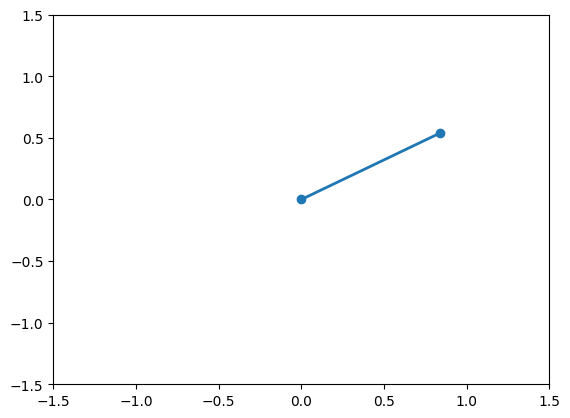

In [43]:
from matplotlib import animation, rc
from IPython.display import HTML

# Define la función de animación
def animate(i):
    line.set_data([0, np.sin(y[i])], [0, np.cos(y[i])])
    return line,

# Crea la figura y los ejes
fig, ax = plt.subplots()
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)

# Crea la línea para la animación
line, = ax.plot([], [], 'o-', lw=2)

# Crea la animación
ani = animation.FuncAnimation(fig, animate, frames=len(y), interval=50, blit=True)

# Muestra la animación
HTML(ani.to_html5_video())